In [1]:
import sys
!conda install --yes --prefix {sys.prefix} descartes

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Nico\Anaconda

  added / updated specs:
    - descartes


The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2020.12.~ --> pkgs/main::ca-certificates-2021.1.19-haa95532_1

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            conda-forge::certifi-2020.12.5-py38ha~ --> pkgs/main::certifi-2020.12.5-py38haa95532_0
  conda              conda-forge::conda-4.9.2-py38haa244fe~ --> pkgs/main::conda-4.9.2-py38haa95532_0
  openssl            conda-forge::openssl-1.1.1j-h8ffe710_0 --> pkgs/main::openssl-1.1.1j-h2bbff1b_0


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [18]:
import geopandas as gpd
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import folium
import geopandas as gpd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
base_dir = 'D:/Università/Tirocinio/Analisi Dati/Dati/'

In [19]:
files = [
#'MarcheQuakeArea_20150416_20150427_24.csv',
#'MarcheQuakeArea_20150516_20150527_24.csv',
#'MarcheQuakeArea_20150916_20150927_24.csv',
'MarcheQuakeArea_20160416_20160427_24.csv',
'MarcheQuakeArea_20160516_20160527_24.csv',
#'MarcheQuakeArea_20160816_20160901_24.csv', # mese del terremoto
#'MarcheQuakeArea_20160916_20160927_24.csv',
'MarcheQuakeArea_20170416_20170427_24.csv',
'MarcheQuakeArea_20170516_20170527_24.csv',
#'MarcheQuakeArea_20170916_20170927_24.csv'
]


data = pd.read_csv(base_dir+'dataset/'+files[0])
for i in range(1,len(files)):
    data = pd.concat([data,pd.read_csv(base_dir+'dataset/'+files[i])])

data = data.dropna(axis='rows')
data['rtime'] = pd.to_datetime(data['time'], format = '%Y%m%d_%H%M')
data.head(2)
#data.info()

,time,rtime,base2mid,val,assoc_comuni,RER_32
0,20160416_0000,2016-04-16,10000 1,12098.0,Monte Urano,0.0
1,20160416_0000,2016-04-16,10001 1,7454.0,Monte San Giusto,0.0


In [20]:
data = data.drop(['time','base2mid'],axis='columns')
data = data.groupby(['rtime','assoc_comuni','RER_32'])['val'].sum().reset_index()
data.assoc_comuni.value_counts()[0:10]

Montecarotto             954
Belforte del Chienti     954
Rapagnano                954
Loreto                   954
Urbisaglia               954
Servigliano              954
Agugliano                954
Serravalle di Chienti    954
Cupra Marittima          954
Massignano               954
Name: assoc_comuni, dtype: int64

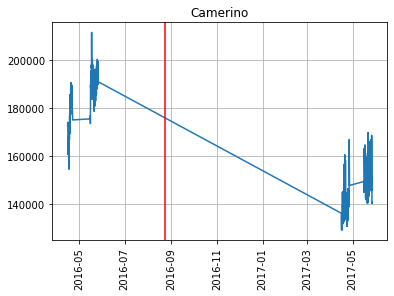

In [21]:
comune = 'Camerino'

ts = data[data['assoc_comuni']==comune]
#ts.index= ts['rtime']
plt.plot(ts['rtime'], ts['val'])
plt.xticks(rotation=90)
plt.title(comune)
plt.grid()
hq_time = datetime.strptime('20160824_0336','%Y%m%d_%H%M')
if ts['rtime'].min() < hq_time and hq_time < ts['rtime'].max():
    plt.axvline(hq_time, color='#ff0000')
plt.show()


#ts = ts['val']
#plt.rcParams['axes.grid'] = True
#plt.rcParams['axes.grid.which'] = 'both'
#plt.rcParams['xtick.minor.visible'] = True
#fig = ts.plot(grid=True)
#fig.set_xlabel("time")
#fig.set_ylabel("num people");
#hq_time = datetime.strptime('20160824_0336','%Y%m%d_%H%M')
#if ts.index.min() < hq_time and hq_time < ts.index.max():
#    plt.axvline(hq_time, color='#ff0000')
#plt.show()
#plt.rcParams.update(plt.rcParamsDefault)

**Fig. 1** Change in population size from April/May 2016 (before the earthquake) and  April/May 2017 (after the earthquake) for Camerino (a city in the quake area)

In [22]:

# compute YoY differenes

def first(x):
    return list(x)[0]

datad = data.copy()
datad['rtime'] = datad['rtime'].apply(lambda t: t.replace(year = 2017))
datad.head()
yoy = datad.groupby(['rtime','assoc_comuni','RER_32']).agg({'val':[np.size,np.diff,first]}).reset_index()
yoy.columns = ['rtime','assoc_comuni','RER_32','size','diff','first']
yoy = yoy[yoy['size'] == 2]
yoy = yoy[yoy['first'] > 10000]
yoy['diff'] = yoy['diff'].apply(lambda x: float(x))
yoy['rel_diff'] = yoy['diff'] / yoy['first']
yoy = yoy.drop(['size','first'], axis='columns')
yoy.head()

,rtime,assoc_comuni,RER_32,diff,rel_diff
1,2017-04-16,Agugliano,0.0,-5061.0,-0.074315
2,2017-04-16,Altidona,0.0,18935.0,0.385649
3,2017-04-16,Amandola,1.0,616.0,0.019263
4,2017-04-16,Ancona,0.0,-73740.0,-0.036989
5,2017-04-16,Apiro,1.0,-2220.0,-0.041223


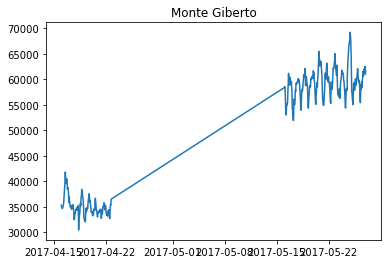

In [23]:
comune = 'Monte Giberto'
ts = yoy[yoy['assoc_comuni']==comune]
#print(ts)
plt.plot(ts['rtime'],ts['diff'])
plt.title(comune)
hq_time = datetime.strptime('20160824_0336','%Y%m%d_%H%M')

**Fig. 2** Difference in population size in April 2017 and May 2017 compared to same months of 2016 in Monte Giberto outside of the quake area 

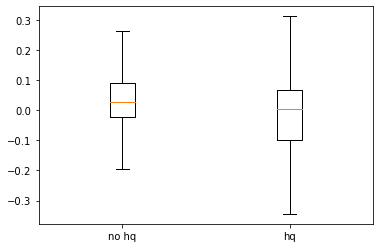

In [24]:

plt.boxplot([yoy[yoy['RER_32']==0]['rel_diff'], yoy[yoy['RER_32']==1]['rel_diff']],showfliers=False)
plt.xticks([1,2], ['no hq','hq'])
plt.show()

In [25]:
map = gpd.read_file(base_dir+'shp\\Comuni2016\\marche.shp')
crateri = pd.read_csv(base_dir+'other_data\\crateriCentroIT.csv',sep=';')
crateri.columns = ['PROV','COMUNE','HQ']
print(crateri.shape)
print(map.shape)
map = map.merge(crateri,how='left')
map['HQ'] = map['HQ'].fillna(0)
print(map.shape)
map = map.loc[:,['COMUNE','geometry','HQ']]
map.head(2)

(131, 3)
(236, 13)
(236, 15)


,COMUNE,geometry,HQ
0,Ripatransone,"POLYGON ((13.79857 43.03372, 13.79856 43.03366...",0.0
1,Trecastelli,"POLYGON ((13.11299 43.72705, 13.11340 43.72703...",0.0


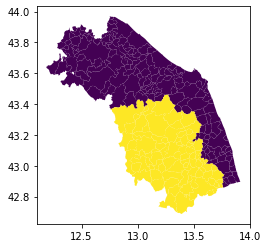

In [26]:
map['HQ'].value_counts()
map.plot(column='HQ');

In [28]:
mean_yoy = yoy.groupby(['assoc_comuni','RER_32'])['rel_diff'].mean().reset_index()
mean_yoy.columns = ['COMUNE','RER_32','YOY']
map_yoy = map.merge(mean_yoy)
map_yoy.shape

(132, 5)

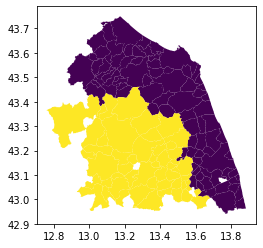

In [27]:
map_yoy['HQ'].value_counts()
map_yoy.plot(column='HQ');

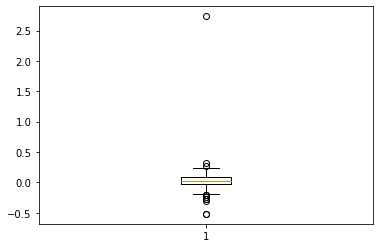

In [29]:
plt.boxplot(map_yoy['YOY']);
map_yoy_clean = map_yoy.drop(map_yoy[map_yoy['YOY']==max(map_yoy['YOY'])].index)

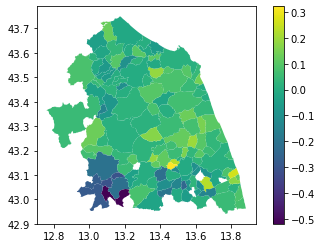

In [31]:
#map_yoy = map_yoy.drop([5,135])
map_yoy_clean.plot(column='YOY', legend=True);

In [15]:
map_yoy_clean.head(2)

,COMUNE,geometry,HQ,RER_32,YOY
0,Ripatransone,"POLYGON ((13.79857 43.03372, 13.79856 43.03366...",0.0,0.0,0.051717
1,Trecastelli,"POLYGON ((13.11299 43.72705, 13.11340 43.72703...",0.0,0.0,0.129712


In [39]:
simple_map = map_yoy_clean.copy()
simple_map = simple_map.to_crs(epsg=4326)
simple_map['geometry'] = simple_map['geometry'].simplify(0.001, preserve_topology=False)
#myscale = (simple_map['YOY'].quantile((0,0.2,0.4,0.6,0.8,1))).tolist()
myscale = [-60, -50,-40,-30,-20,-10,0,10,20,30,40,50]

In [41]:


def style_function(x):
    color = '#ff0000' if x['properties']['RER_32'] == 1 else '#000000'
    fill = '#ff7777' if x['properties']['RER_32'] == 1 else '#ffffff'
    #print(x['properties']['RER_32'])
    return {'fillColor': fill, 
            'color':color, 
            'fillOpacity': 0.1, 
            'weight': 0.5}

def highlight_function(x):
    color = '#ff0000' if x['properties']['RER_32'] == 1 else '#000000'
    fill = '#990000' if x['properties']['RER_32'] == 1 else '#000000'
    return {'fillColor': fill, 
            'color':color, 
            'fillOpacity': 0.50, 
            'weight': 0.1}


other = folium.features.GeoJson(
    simple_map,
    style_function=style_function,
    control=False,
    highlight_function=highlight_function,
    tooltip=folium.features.GeoJsonTooltip(
        fields=['COMUNE','RER_32','YOY'],
        aliases=['Comune: ','HQ_AREA','YOY change %: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")
    )
)

m = folium.Map(location=[simple_map.centroid.y.mean(), simple_map.centroid.x.mean()], tiles="cartodbpositron", zoom_start=8)

folium.Choropleth(
 geo_data=simple_map,
 name='Choropleth',
 data=simple_map,
 columns=['COMUNE','YOY'],
 key_on="feature.properties.COMUNE",
 fill_color='RdBu',
 threshold_scale= myscale,
 fill_opacity=1,
 line_opacity=0.2,
 legend_name='YOY %',
 smooth_factor=0
).add_to(m)

m.add_child(other)
m.keep_in_front(other)
folium.LayerControl().add_to(m)
m




<ipython-input-41-f8315f894dd5>:31: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[simple_map.centroid.y.mean(), simple_map.centroid.x.mean()], tiles="cartodbpositron", zoom_start=8)
